<a href="https://colab.research.google.com/github/ashinshanly/BERT-FineTuned-RD/blob/main/Fine_Tuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [ ]:
# 1
!pip install transformers==3

     |████████████████████████████████| 757kB 8.1MB/s 
     |████████████████████████████████| 3.0MB 17.1MB/s 
     |████████████████████████████████| 890kB 39.2MB/s 
     |████████████████████████████████| 1.1MB 56.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=44a406775863ff0d02bf9a32fd518eef32b22e281294dd121cdb66edacb27b0e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# 2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda:0")

In [ ]:
# 3
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
# 4
df = pd.read_csv("/content/drive/MyDrive/ReverseDictionary/data/dataset2.csv")
df.head()

,label,text
0,abandon,Cease to support or look after (someone)
1,abandon,desert
2,ability,Possession of the means or skill to do something
3,able,Having the power skill means or opportunity to...
4,abortion,The deliberate termination of a human pregnanc...


In [ ]:
# 5
df.shape

(3281, 2)

In [ ]:
# 6
# check class distribution
df['label'].value_counts(normalize = True)

first       0.000914
quite       0.000914
one         0.000914
universe    0.000914
thirty      0.000914
              ...   
dear        0.000305
pepper      0.000305
desk        0.000305
forget      0.000305
quiet       0.000305
Name: label, Length: 2842, dtype: float64

In [ ]:
# 7
series=df['label']
series.tolist()

word2idx={}
idx2word=[]
for word in series:
  if word not in word2idx:
    word2idx[word]=len(word2idx)
    idx2word.append(word)
print(word2idx)
print(len(word2idx))

{'abandon': 0, 'ability': 1, 'able': 2, 'abortion': 3, 'about': 4, 'above': 5, 'abroad': 6, 'absence': 7, 'absolute': 8, 'absolutely': 9, 'absorb': 10, 'abuse': 11, 'academic': 12, 'accept': 13, 'access': 14, 'accident': 15, 'accompany': 16, 'accomplish': 17, 'according': 18, 'account': 19, 'accurate': 20, 'accuse': 21, 'achieve': 22, 'achievement': 23, 'acid': 24, 'acknowledge': 25, 'acquire': 26, 'across': 27, 'act': 28, 'action': 29, 'active': 30, 'activist': 31, 'activity': 32, 'actor': 33, 'actress': 34, 'actual': 35, 'actually': 36, 'ad': 37, 'adapt': 38, 'add': 39, 'addition': 40, 'additional': 41, 'address': 42, 'adequate': 43, 'adjust': 44, 'adjustment': 45, 'administration': 46, 'administrator': 47, 'admire': 48, 'admission': 49, 'admit': 50, 'adolescent': 51, 'adopt': 52, 'adult': 53, 'advance': 54, 'advanced': 55, 'advantage': 56, 'adventure': 57, 'advertising': 58, 'advice': 59, 'advise': 60, 'adviser': 61, 'advocate': 62, 'affair': 63, 'affect': 64, 'afford': 65, 'afraid'

# Split train dataset into train, validation and test sets

In [ ]:
# 8
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5)

# Import BERT Model and BERT Tokenizer

In [ ]:
# 9
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

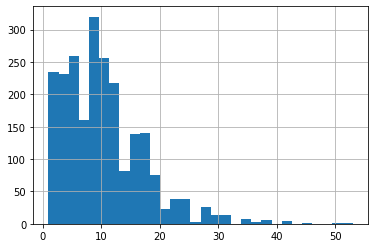

In [ ]:
# 10
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# 11
max_seq_len = 25

In [ ]:
# 12
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [ ]:
# 13
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
# train_y = torch.tensor(train_labels.tolist())

train_labels_index = []
for i in train_labels:
    train_labels_index.append(word2idx[i])
# print(train_labels_index)
train_y = torch.tensor(train_labels_index)
print(train_seq)
print(train_mask)
print(train_y)
#train_y = torch.tensor(tokens_train_y['input_ids'])

# for validation set
val_labels_index = []
for i in val_labels:
    val_labels_index.append(word2idx[i])
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels_index)

# for test set
test_labels_index = []
for i in test_labels:
    test_labels_index.append(word2idx[i])
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels_index)

tensor([[  101,  2191,  1037,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101, 11158,  7182,  ...,     0,     0,     0],
        ...,
        [  101,  3701,   102,  ...,     0,     0,     0],
        [  101,  1037,  2601,  ...,     0,     0,     0],
        [  101,  8800,  2000,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([ 172, 2696, 1941,  ..., 1997, 2324, 1140])


# Create DataLoaders

In [ ]:
# 14
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# 15
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
# 16
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,len(word2idx))
      #self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# 17
# pass the pre-trained BERT to our defined architecture
model = BERT_Arch(bert)
# push the model to GPU
#model = model.to(device)

In [ ]:
# 18
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [ ]:
# 19
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels_index), train_labels_index)

print(class_wts)
print(len(class_wts))

[0.55432158 1.10864317 1.10864317 ... 1.10864317 1.10864317 1.10864317]
2071


In [ ]:
# 20
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
#weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy  = nn.NLLLoss(weight=None)  ###
#criterion=nn.BCELoss()
# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    # batch = [r.to(device) for r in batch]
    
    sent_id, mask, labels = batch
    # sent_id.to(device)
    # mask.to(device)
    # labels.to(device)
    # print(sent_id)
    # print("MASK")
    # print(mask)
    # clear previously calculated gradients 
    model.zero_grad()        
    # print("I am Here")
    # get model predictions for the current batch

    preds = model(sent_id, mask)

    # print("I am Here too")
    # print(preds)
    # print(len(preds))
    # print(preds.shape)
    # print(labels)
    # print(len(labels))
    # print(labels.shape)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    #loss=criterion(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
  #  batch = [t.to(device) for t in batch]
#    model.to(device)
    sent_id, mask, labels = batch
    # sent_id.to(device)
    # mask.to(device)
    # labels.to(device)
    # outputs = model(**inputs)
    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Load Saved Model

In [ ]:
# 21
#load weights of best model
path = '/content/drive/MyDrive/ReverseDictionary/models/saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(10):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/ReverseDictionary/models/saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 7.199
Validation Loss: 11.924

 Epoch 2 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 7.155
Validation Loss: 12.230

 Epoch 3 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 7.090
Validation Loss: 13.165

 Epoch 4 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 7.028
Validation Loss: 13.907

 Epoch 5 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 6.979
Validation Loss: 14.605

 Epoch 6 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 6.948
Validation Loss: 14.630

 Epoch 7 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 6.896
Validation Loss: 15.271

 Epoch 8 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 6.866
Validation Loss: 15.834

 Epoch 9 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 6.831
Validation Loss: 16.133

 Epoch 10 / 10
  Batch    50  of     72.

Evaluating...

Training Loss: 6.820
Val

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()
  preds

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
import numpy as np
def evaluate(ground_truth, prediction):
   accu_1 = 0.
   accu_10 = 0.
   accu_100 = 0.
   length = len(ground_truth)
   for i in range(length):
       if ground_truth[i] in prediction[i][:100]:
           accu_100 += 1
           if ground_truth[i] in prediction[i][:10]:
               accu_10 += 1
               if ground_truth[i] == prediction[i][0]:
                   accu_1 += 1
   return accu_1/length*100, accu_10/length*100, accu_100/length*100

def evaluate_test(ground_truth, prediction):
   # print(ground_truth)
   # print(prediction)
   accu_1 = 0.
   accu_10 = 0.
   accu_100 = 0.
   length = len(ground_truth)
   l = 0
   pred_rank = []
   for i in range(length):
      #  print(prediction[i].tolist().index(ground_truth[i]))
       try:
           pred_rank.append(prediction[i].tolist().index(ground_truth[i]))
           l = l+1
       except:
           pred_rank.append(1000)

       if ground_truth[i] in prediction[i][:100]:
           accu_100 += 1
           if ground_truth[i] in prediction[i][:10]:
               accu_10 += 1
               if ground_truth[i] == prediction[i][0]:
                   accu_1 += 1
   actual_pred_rank = []  
   for i in range(length):
     if(pred_rank[i]!=1000):
        actual_pred_rank.append(pred_rank[i])
   print(actual_pred_rank)
   return accu_1/l*100, accu_10/l*100, accu_100/l*100, np.median(actual_pred_rank), np.sqrt(np.var(actual_pred_rank))


In [ ]:
predictions = []
ground_truth = []
test = open('/content/drive/MyDrive/ReverseDictionary/data/dataset2.csv', 'r')
#test = open('dataset9.txt', 'r')
for i, line in enumerate(test):
    print(line)
    if(i==200):
      break
    else:
      print("Testing " + str(i) + "/200")
    line = line.strip('\n').split(',')
    # if(line[0] not in idx2word):
    #   continue
    ground_truth.append(word2idx[line[0]])
    # print(ground_truth)
    a = line[1]
    text = []
    text.append(a)
    sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
    seq = torch.tensor(sent_id['input_ids'])
    # print(seq)
    mask = torch.tensor(sent_id['attention_mask'])
    # mask
    preds=model(seq,mask)
    preds = preds.detach().cpu().numpy()
    #print(np.argmax(bert(seq)))
    ind=np.argpartition(preds[0],-100)[-100:]
    predictions.append(ind)
    # print(predictions)

A_1,A_10,A_100,med,sq = evaluate_test(ground_truth,predictions)
print("Accuracy @ 1 = "+ str(A_1))
print("Accuracy @ 10 = "+ str(A_10))
print("Accuracy @ 100 = "+ str(A_100))
print("Median Prediction Rank = "+ str(med))
print("Variance = "+ sq)

label,text

Testing 0/200
abandon,Cease to support or look after (someone)

Testing 1/200
abandon,desert

Testing 2/200
ability,Possession of the means or skill to do something

Testing 3/200
able,Having the power skill means or opportunity to do something

Testing 4/200
abortion,The deliberate termination of a human pregnancy most often performed during the first 28 weeks of pregnancy

Testing 5/200
about,On the subject of

Testing 6/200
about,concerning

Testing 7/200
above,In extended space over and not touching

Testing 8/200
abroad,In or to a foreign country or countries

Testing 9/200
absence,The state of being away from a place or person

Testing 10/200
absolute,Not qualified or diminished in any way

Testing 11/200
absolute,total

Testing 12/200
absolutely,With no qualification restriction or limitation

Testing 13/200
absolutely,totally

Testing 14/200
absorb,Take in or soak up (energy or a liquid or other substance) by chemical or physical action

Testing 15/200
abuse,Use (so

TypeError: ignored

In [ ]:
a = input()
text = []
text.append(a)
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

seq = torch.tensor(sent_id['input_ids'])
# print(seq)
mask = torch.tensor(sent_id['attention_mask'])
# mask
preds=model(seq,mask)
preds = preds.detach().cpu().numpy()
#answer=int((np.argmax(preds, axis = None)+np.argmin(preds, axis = None))/2)
print(preds)
answer=np.argmin(preds, axis=1)
print(answer[0])
idx2word[answer[0]]
# print(model.predict_class(seq))
#print(np.argmax(bert(seq)))
ind=np.argpartition(preds[0],-10)[-10:]
meanings=[]
for i in ind:
    meanings.append(idx2word[i])
print(meanings)

happines
[[ -6.407955  -8.473671 -15.365709 ... -15.346077 -15.245441 -12.765114]]
1273
['honor', 'nobody', 'ultimately', 'five', 'first', 'hundred', 'somewhat', 'thirty', 'nevertheless', 'ten']


In [ ]:
# 22
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify, render_template, logging 
import webbrowser 

In [ ]:
# 23
def create_app():
    app = Flask(__name__, template_folder='/content/drive/MyDrive/Colab Notebooks/templates', static_folder='/content/drive/MyDrive/Colab Notebooks/static')  
    return app
    
app = create_app()

#WEB-APP
@app.route('/', methods=['GET', 'POST'])
def index():
    meanings=[]
    if request.method == 'POST':
        words = request.form['definition'].split()        
        sent_id = tokenizer.batch_encode_plus(words, padding=True, return_token_type_ids=False)
        seq = torch.tensor(sent_id['input_ids'])
        mask = torch.tensor(sent_id['attention_mask'])
        preds=model(seq,mask)
        preds = preds.detach().cpu().numpy()
        ind=np.argpartition(preds[0],-10)[-10:]
        meanings=[]
        for i in ind:
            meanings.append(idx2word[i])
        return jsonify(meanings)        
    else:
        #return "<h1>Running Flask on Google Colab!</h1>"
        return render_template('indexBERT.html')


run_with_ngrok(app) 
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://e8c85b68f812.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [07/Dec/2020 04:30:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:30:43] "GET /static/js/main.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:30:43] "GET /static/js/jquery-3.3.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:30:43] "GET /static/css/bulma/bulma.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:30:47] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [07/Dec/2020 04:44:49] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:45:05] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:45:23] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:45:45] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:45:50] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:45:52] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:45:54] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:46:05] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:46:23] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 04:46:37] "POST / HTTP/1.1" 200 -
127